# Gravitational Lensing of 4 galaxies placed at different redshift
# and a dark matter halo moving across redshift

#### The aim is to create an animation (.gif for example) with the output .png files.
#### Part of the code is credited to GalSim tutorials (https://galsim-developers.github.io/GalSim/_build/html/tutorials.html).

In [57]:
import galsim
import matplotlib.pyplot as plt
import numpy as np
import math

In [58]:
# (Optional) Set text font to LaTeX typography. TeX Live package is needed.

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer modern"],  # You can change the serif font here if needed
    "axes.labelsize": 14,     # Adjust as needed
    "axes.linewidth": 0.5,    # Adjust line width if necessary
    "xtick.labelsize": 12,    # Adjust tick label size
    "ytick.labelsize": 12,    # Adjust tick label size
    "legend.fontsize": 12,    # Adjust legend font size
    "legend.handlelength": 2.0
})

In [59]:
# Define the parameters of the galaxies.

nobj = 4 # Number of galaxies. Code is only prepared for 4 galaxies.

nfw_z_source = [0.05,0.2,0.4,0.6]  # Redshift of the lensed sources (galaxies).

gal_r_min = 2.0  # arcsec
gal_r_max = 2.7  # arcsec
gal_h_over_r_min = 0.1
gal_h_over_r_max = 0.2

gal_flux_min = 1.e4  # ADU
gal_flux_max = 1.e6  # ADU

pos_x = [-0.5,0.5,-0.5,0.5]
pos_y = [0.5,0.5,-0.5,-0.5]
radius = 25

In [60]:
# Standard parameters and configurations needed to simulate. 

galsim.config.GSParams.maximum_fft_size = 15000
random_seed = 8383721
rng = galsim.BaseDeviate(random_seed + 1)
image_size = 1000 # pixels
sky_level = 1.e2  # ADU / arcsec^2
pixel_scale = 0.26 # arsec / pixel
sky_level_pixel = sky_level * pixel_scale**2 # Add noise to the galaxies.
noise = galsim.PoissonNoise(rng, sky_level=sky_level_pixel)

field_g1 = 0.03  # The field shear is some cosmic shear applied to the whole field,
field_g2 = 0.01  # Taken to be behind the foreground NFW halo.
nfw_conc = 4  # Concentration parameter = virial radius / NFW scale radius.
omega_m = 0.3  # Omega matter for the background cosmology.
omega_lam = 0.7  # Omega lambda for the background cosmology.

field_shear = galsim.Shear(g1=field_g1, g2=field_g2)

In [138]:
# Previous definitions, lists and parameters before starting the simulation.

steps = 60
mass = 3*1.e15 # Implausible halo mass.
z_list = np.linspace(0.01,0.8,num=1000)

c = ['b','g','c','m'] # Colour for every galaxy.

In [139]:
# Definition of galaxy function

def galaxy(ud,pos_x,pos_y,source,radius):
        radius=radius
        inner_radius = 5
        max_rsq = radius**2
        min_rsq = inner_radius**2

        while True:
            x = pos_x * radius
            y = pos_y * radius
            rsq = x**2 + y**2
            if min_rsq <= rsq <= max_rsq:
                break

        pos = galsim.PositionD(x, y)
        image_pos = wcs.toImage(pos)

        # Definition of the galaxy flux
        flux_dist = galsim.DistDeviate(ud, function=lambda x: x**-1.5,
                                   x_min=gal_flux_min, x_max=gal_flux_max)
        flux = flux_dist()

        # Definition of an arbitrary inclination for the galaxy around x axis.
        inc_dist = galsim.DistDeviate(ud, function=lambda x: math.sin(x),
                                  x_min=0, x_max=math.pi)
        inclination = inc_dist() * galsim.radians  #
        theta = ud() * math.pi * 2 * galsim.radians
    
        h_over_r = ud() * (gal_h_over_r_max - gal_h_over_r_min) + gal_h_over_r_min
        radius = ud() * (gal_r_max - gal_r_min) + gal_r_min

        # Creation of the galaxy profile.
        gal = galsim.InclinedExponential(scale_radius=radius,
                                     scale_h_over_r=h_over_r,
                                     inclination=inclination, flux=flux)

        gal = gal.rotate(theta)

        # Calculating the shear caused by the dark matter halo.    
        if source >= nfw_z_halo:
            try:
                g1, g2 = nfw.getShear(pos, source)
                nfw_shear = galsim.Shear(g1=g1, g2=g2)
            except Exception as e:
                print("Warning: NFWHalo shear is invalid -- probably strong lensing! Using shear = 0. Error: {e}")
                nfw_shear = galsim.Shear(g1=0, g2=0)
        else:
            nfw_shear = galsim.Shear(g1=0, g2=0)

        total_shear = field_shear + nfw_shear
        gal = gal.shear(total_shear)
        
        local_wcs = wcs.local(image_pos)

        g=np.sqrt((nfw_shear.g1)**2+(nfw_shear.g2)**2)
    
        return gal, pos, local_wcs, image_pos, g, x, y

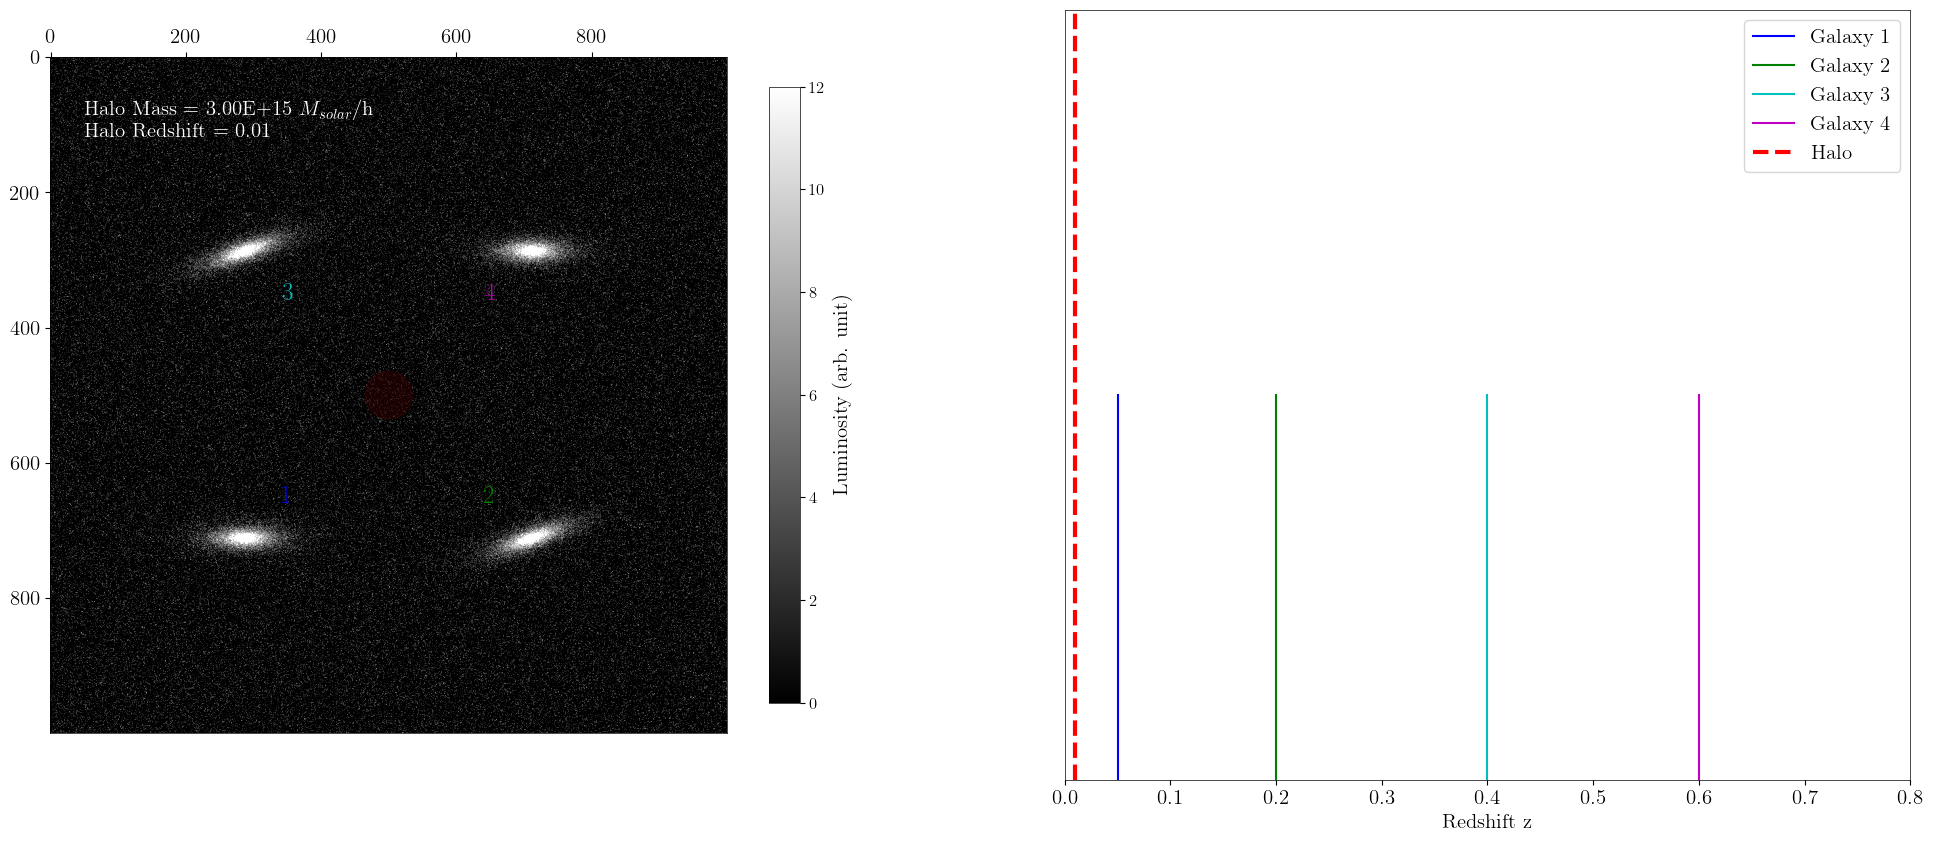

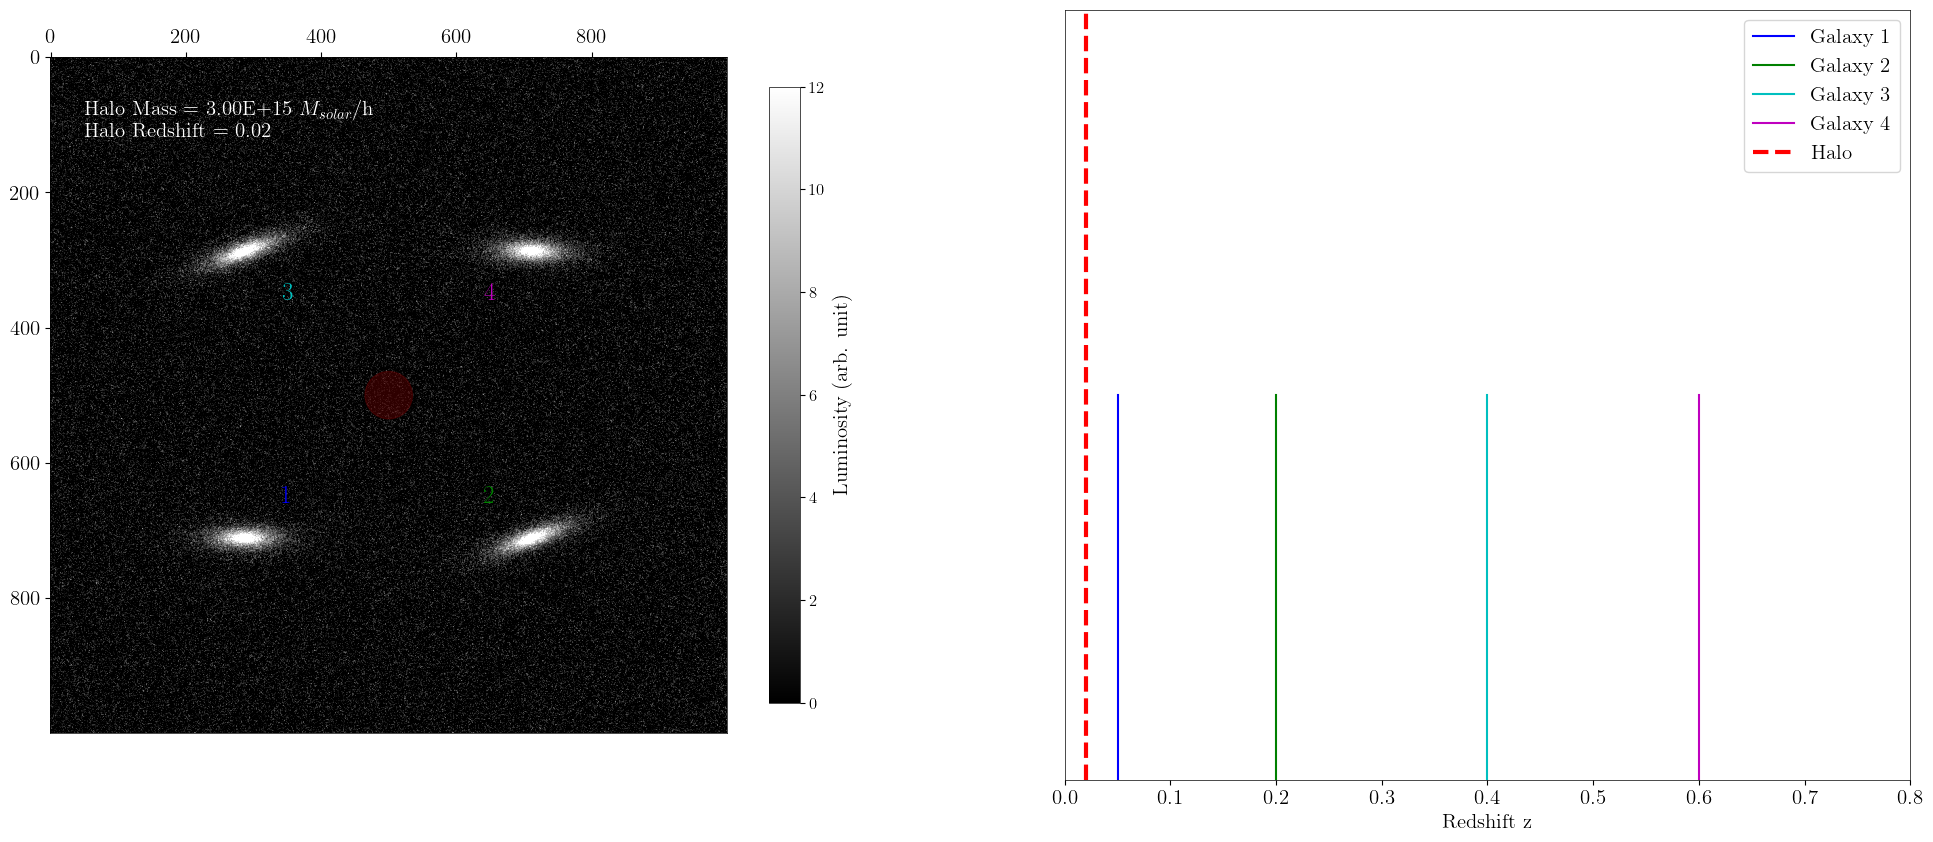

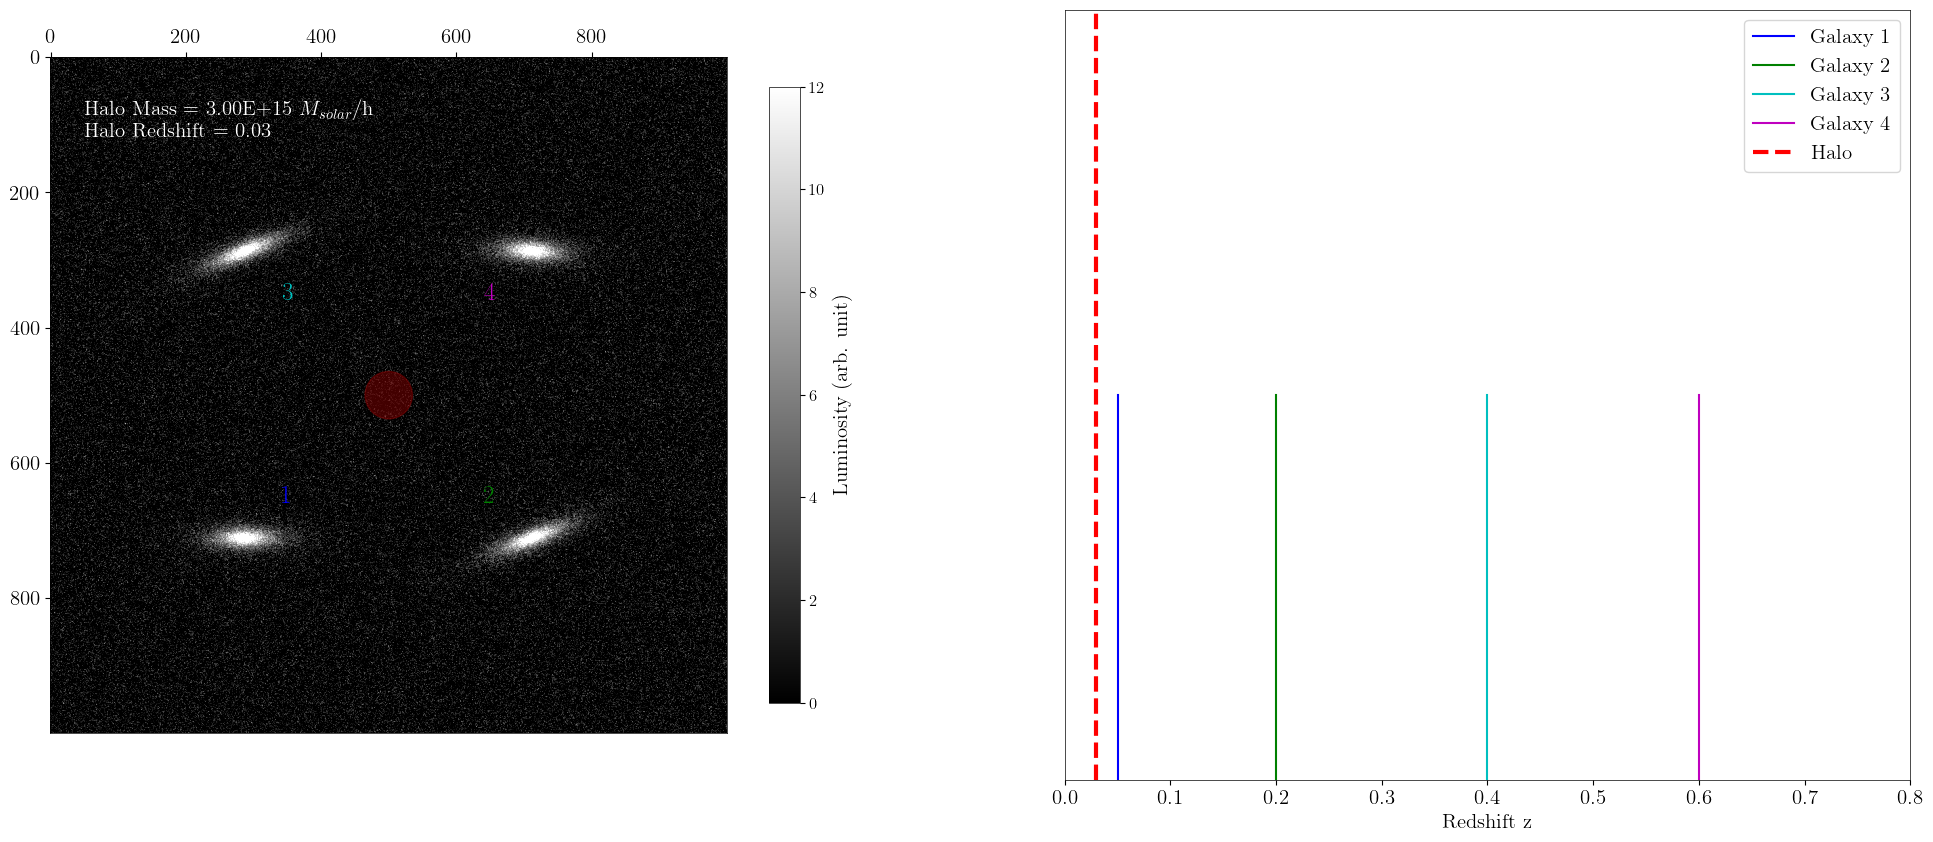

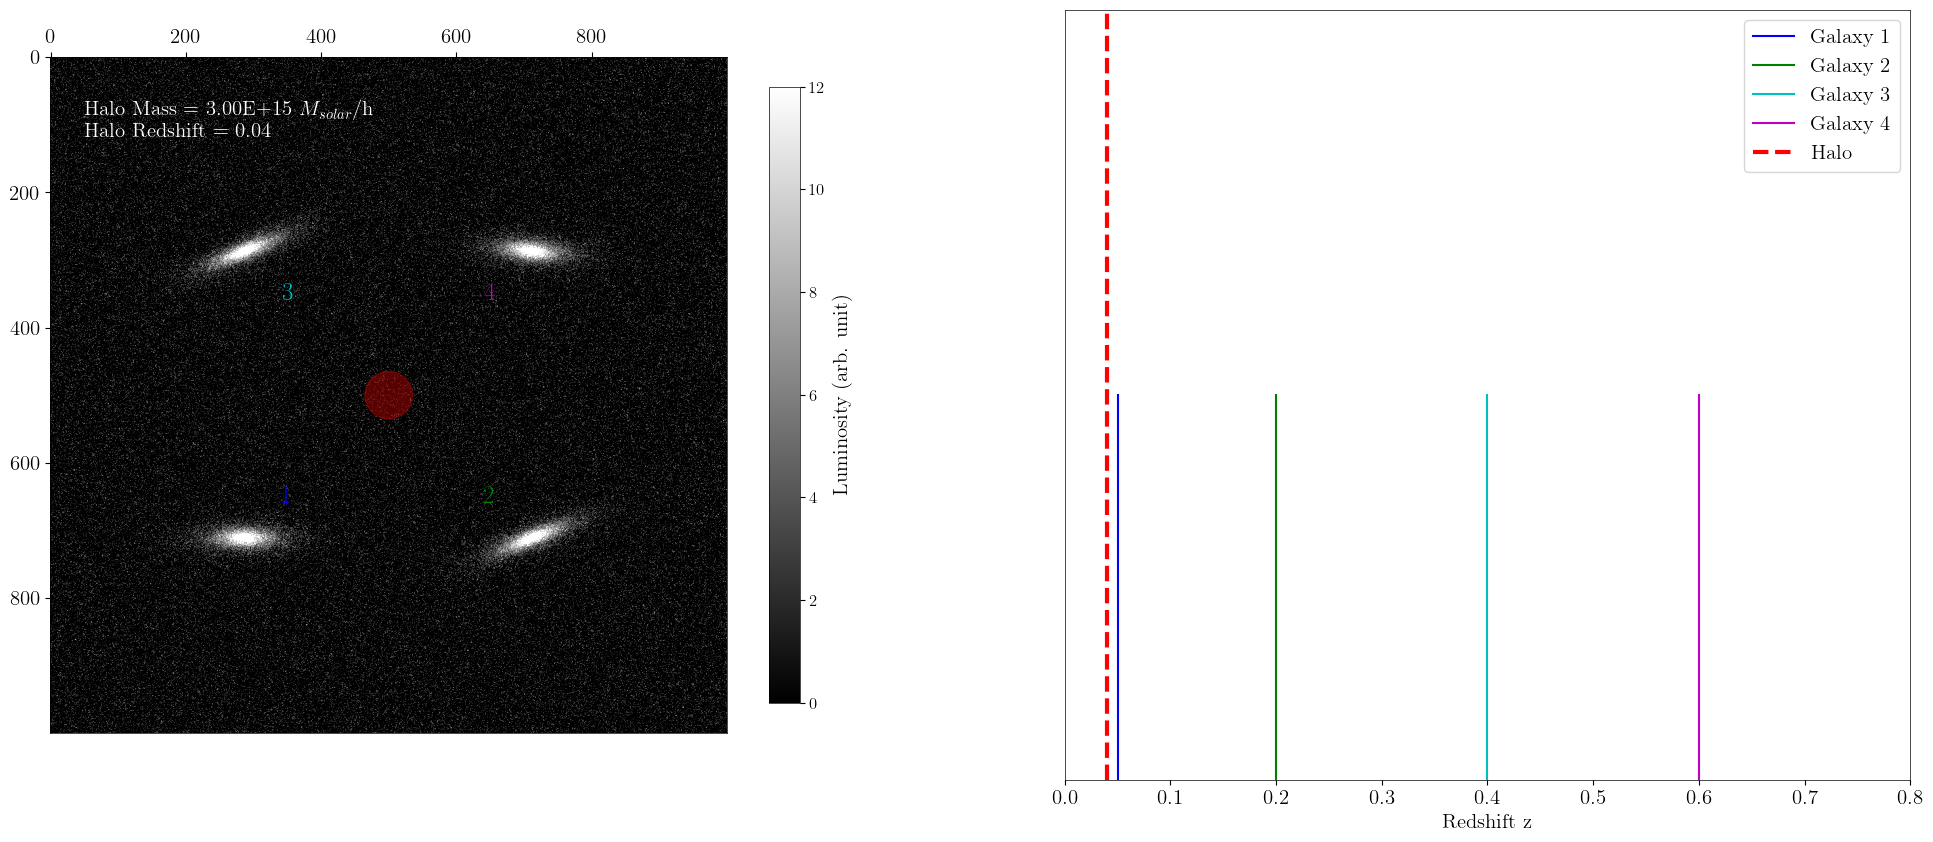

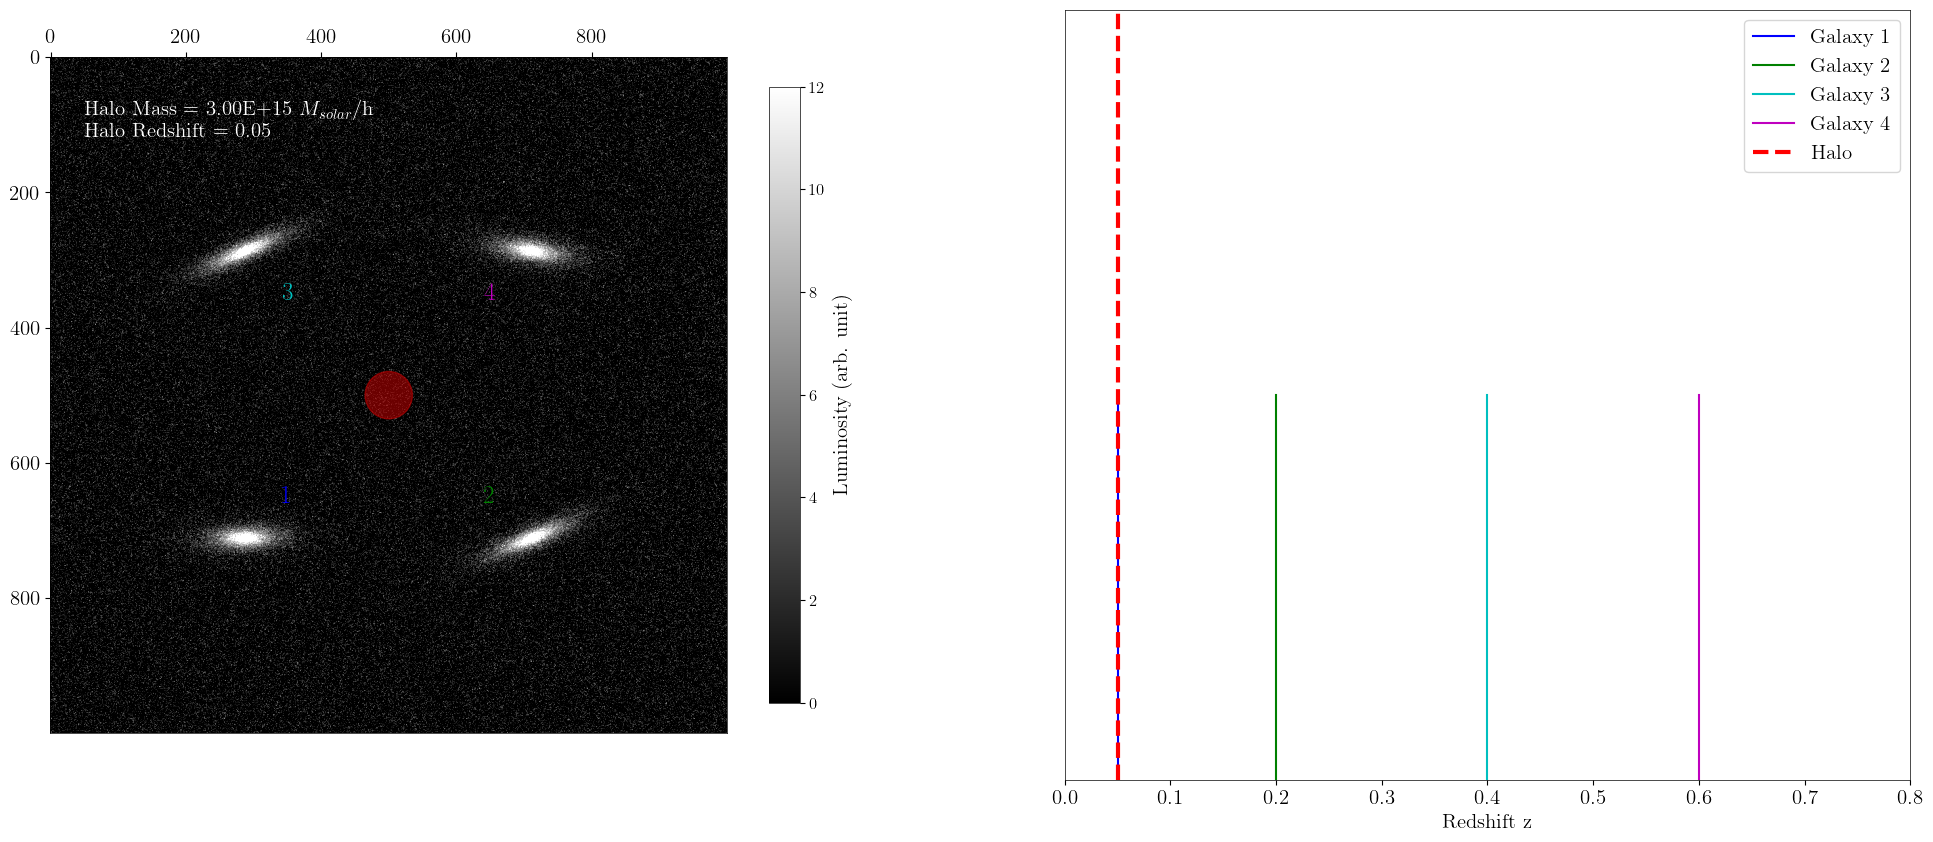

In [140]:
# Simulation code.

z_list = []
nfw_shear_list = []

for k in range(nobj):
    nfw_shear_list.append([])

for i in range(steps):
    nfw_z_halo = 0.01*(i+1)  # Redshift of the halo.
    z_list.append(nfw_z_halo)

    # Creation of the image to plot the galaxies.
    full_image = galsim.ImageF(image_size, image_size, scale=pixel_scale)
    im_center = full_image.true_center # Center of the created image.
    full_image.addNoise(noise) #Add noise.

    # NFW halo for lensing
    cosmo = galsim.Cosmology(omega_m=omega_m, omega_lam=omega_lam)

    nfw = galsim.NFWHalo(mass=mass, conc=nfw_conc, redshift=nfw_z_halo, cosmo=cosmo)

    ufunc = '0.05 * x * (1. + 2.e-6 * (x**2 + y**2))'
    vfunc = '0.05 * y * (1. + 2.e-6 * (x**2 + y**2))'
    xfunc = ('( lambda w: ( 0 if w==0 else ' + '100.*u/w*(( 5*(w**2 + 5.e3/27.)**0.5 + 5*w )**(1./3.) - ' + '( 5*(w**2 + 5.e3/27.)**0.5 - 5*w )**(1./3.))))( (u**2+v**2)**0.5 )')
    yfunc = ('( lambda w: ( 0 if w==0 else ' + '100.*v/w*(( 5*(w**2 + 5.e3/27.)**0.5 + 5*w )**(1./3.) - ' + '( 5*(w**2 + 5.e3/27.)**0.5 - 5*w )**(1./3.))))( (u**2+v**2)**0.5 )')
    wcs = galsim.UVFunction(ufunc, vfunc, xfunc, yfunc, origin=im_center)
    full_image.wcs = wcs

    # Construction of the galaxies and the output figure.
    fig, (ax1, ax2) = plt.subplots(figsize=(24,10), ncols=2)
    for k in range(nobj):
        r = galsim.UniformDeviate(random_seed)
        source = nfw_z_source[k]
        gal, pos, local_wcs, image_pos, g,x,y = galaxy(r,pos_x[k],pos_y[k],source,radius)
        gal.drawImage(wcs=local_wcs, center=image_pos, image=full_image, method='auto', add_to_image=True)
        nfw_shear_list[k].append(g)
    
    im1 = ax1.imshow(full_image.array, cmap='binary_r',vmin=0,vmax=12)
    cbar = fig.colorbar(im1, ax=ax1, orientation='vertical', shrink=0.8)
    cbar.set_label(label='Luminosity (arb. unit)',size=15)
    ax1.text(0.05*image_size,0.15*image_size,'Halo Mass = '+"%.2E"%mass+' $M_{solar}$/h'+'\n'+'Halo Redshift = '+"%0.2f"%nfw_z_halo+'\n',color='w',fontsize=15) #+'galaxies redshift = '+str(nfw_z_source)+'\n'
    circle = plt.Circle((image_size/2, image_size/2), 20+mass/(2.e14), color=(0.2+i/steps*0.8,0,0), alpha=0.5, edgecolor=None)  # Centro en (50, 50), radio 20, color rojo, transparencia 50%
    ax1.add_patch(circle)
    ax1.tick_params(labelsize=15)
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    for t in range(len(pos_x)):
        ax1.text(300*(pos_x[t])+0.5*image_size, 300*(pos_y[t])+0.5*image_size, str(t+1), c=c[t], fontsize=18, ha='center', va='center')

    # Plot in the right. Galaxy matter distribution across redshift.
    mu = nfw_z_halo
    halo_y_list=[]
    for k in range(nobj):
        galaxy_y_list=[]
        ax2.axvline(nfw_z_source[k], c=c[k],ymax=0.5, linewidth=1.5, markersize=1,label='Galaxy '+str(k+1))
    ax2.axvline(mu, c='r', linewidth=3, markersize=1,label='Halo',linestyle='--')
    ax2.set_xlim(0,0.8)
    plt.axis()
    ax2.set_xlabel('Redshift z', fontsize=15)
    ax.set_ylabel('Density distribution', fontsize=15)
    ax2.tick_params(labelsize=15)
    plt.gca().yaxis.set_ticks([])
    plt.legend(fontsize=15)
    ax1.tick_params(labelsize=15)
    plt.savefig("Output%02d"%i+".png", bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

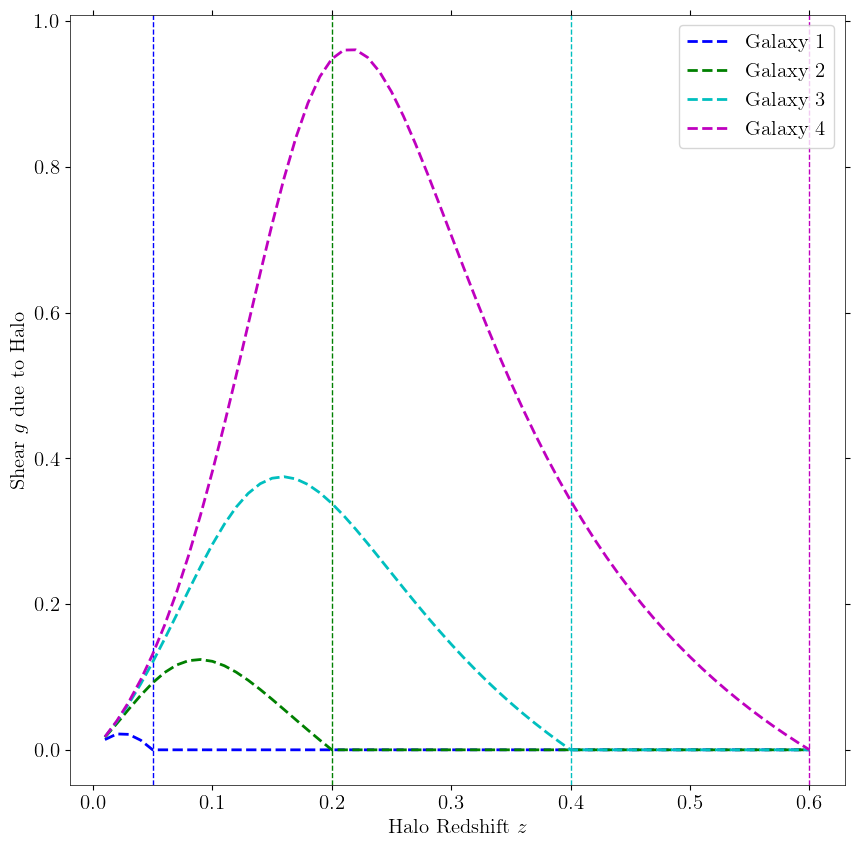

In [137]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis()
for k in range(nobj):
    plt.plot(z_list,nfw_shear_list[k], c=c[k], linestyle='--', linewidth=2, markersize=2,label="Galaxy "+str(k+1))
    plt.axvline(nfw_z_source[k], c=c[k], linewidth=1, markersize=1,linestyle='--')
ax.set_xlabel('Halo Redshift $z$', fontsize=15)  # Adjust font size as needed
ax.set_ylabel('Shear $g$ due to Halo', fontsize=15)  # Adjust font size as needed
plt.legend(fontsize=15)
ax.tick_params(labelsize=15)
plt.tick_params(top=True, labeltop=False)
plt.tick_params(right=True, labelright=False)
plt.savefig('Plot_Shear_vs_Redshift'+".png", bbox_inches='tight',dpi=300)
plt.show()
plt.close()